In [1]:
# get responsivity of all neurons with adjustible window
# assess for neuron-type level effects
# plot examples
# indivdual trial variability

In [161]:
from drn_interactions.spikes import SpikesHandler
from drn_interactions.load import get_fig_dir, load_events, load_spikes, load_neurons_derived
from drn_interactions.transforms import align_to_data_by
from drn_interactions.stats import mannwhitneyu_plusplus
from binit.bin import which_bin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from spiketimes.df.surrogates import shuffled_isi_spiketrains_by
import pingouin as pg
from IPython.display import display


In [143]:
sns.set_theme(style="ticks", context="poster")

outdir = get_fig_dir() / "base_shock"
outdir.mkdir(exist_ok=True, parents=True)
neurons = load_neurons_derived()
neurons_sub = neurons[["neuron_id", "session_name"]]
df_events = load_events("base_shock")
sessions = neurons_sub.merge(df_events[["session_name"]]).session_name.unique()

df_spikes = load_spikes("base_shock").merge(neurons_sub)


In [213]:
class ShockUtils:

    def aligned_binned_from_spikes(self, df_spikes, df_events, session=None, bin_width=0.02):
        import warnings

        if session is not None:
            df_spikes = df_spikes.query("session_name == @session")
            df_events = df_events.query("session_name == @session")


        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            df = align_to_data_by(
                df_spikes, 
                df_events,
                time_before_event=0.5,
                time_after_event=1.5,
                df_data_group_col="session_name",
                df_events_group_colname="session_name",
                df_events_timestamp_col="event_s",
                df_data_time_col="spiketimes"
            )
        bins = np.arange(-0.5, 1.5, bin_width)
        df["bin"] = np.round(which_bin(df["aligned"].values, bins), 2)
        df = df.groupby(["neuron_id", "event", "bin"]).apply(len).to_frame("counts").reset_index()
        return df.pivot(index=["event", "bin"], columns="neuron_id", values="counts").fillna(0).reset_index()
    
    def population_from_aligned_binned(self, df_aligned_binned):
         return (
            df_aligned_binned
            .melt(id_vars=["event", "bin"], var_name="neuron_id")
            .groupby(["event", "bin"], as_index=False)["value"]
            .mean()
        )

    def average_trace_from_aligned_binned(self, df_aligned_binned):
        return df_aligned_binned.drop("event", axis=1).groupby(["bin"]).mean()
    
    def average_population_from_population(self, df_population):
        return df_population.groupby("bin", as_index=False)["value"].mean()


class ClusterUtils:

    def cluster_from_piv(self, df_binned_piv, clusters):
        neurons_by_cluster = {cluster: clusters.query("wf_3 == @cluster").neuron_id.unique() for cluster in clusters["wf_3"].unique()}
        df_by_clusteer = {cluster: df_binned_piv[[c for c in df_binned_piv.columns if c in cluster_neurons]] for cluster, cluster_neurons in neurons_by_cluster.items()}
        return df_by_clusteer


In [ ]:
class ShockPlotter:

    def psth_heatmap_all(self, df_binned_piv, responders=None):
        # create psth
        df_avg = transformer.average_trace_from_aligned_binned(df_aligned).apply(gaussian_filter1d, sigma=2).apply(zscore)
        
        # order psth by responders
        ...
    
    def psth_heatmap_by_cluster(self):
        ...
    
    def unit_raster_across_trials(self):
        ...
    
    def unit_heatmap_across_trials(self):
        ...
    
    def population_single_trial(self):
        ...
    
    def population_heatmap_across_trials(self):
        ...

In [198]:
class ShortTSResponders:
    def __init__(self, window=(0.1, 0.3)):
        self.window = window
        self.transformer = ShockUtils()

    def get_responders(self):
        ...


class ShortTsWilcox(ShortTSResponders):
    def get_responders(self, df_binned_aligned):
        # summary func pre post by trial. adjusted AUC by default.
        ...


class ShortTsAvg(ShortTSResponders):
    # group level anova

    def get_responders(self, df_binned_aligned, z=False):
        avg_trace = self.transformer.average_trace_from_aligned_binned(
            df_binned_aligned
        )
        if z:
            avg_trace = avg_trace.apply(zscore)
        df_res = avg_trace.apply(self._comp_one_col, window=self.window).round(3)
        self.responders = df_res.transpose()
        return self.responders
    
    def plot_responders(self, responders, clusters=None):
        dfp = responders.reset_index().copy()
        dfp["Sig"] = dfp["p"] < 0.05 
        bins = np.arange(-2.1, 2.1, 0.2)  # TODO FIX

        if clusters is None:
            _, ax = plt.subplots(figsize=(5, 5))
            ax =  sns.histplot(data=dfp, x="Diff", color="black", bins=100, ax=ax)
            ax.set_xlabel("Spike Rate Change\n[Z Score]")
            ax.set_ylabel("Unit Counts")
        
        else:
            dfp = dfp.merge(clusters)
            g = sns.FacetGrid(dfp, row="wf_3", sharey=False, aspect=2).map_dataframe(sns.histplot, x="Diff", hue="Sig", multiple="stack", alpha=1, bins=bins)
            g.set_axis_labels(x_var="Spike Rate Change\n[Z Score]", y_var="Unit Counts")
            return g



    @staticmethod
    def _comp_one_col(ser, window, names=("Pre", "Post")):
        x = ser[(ser.index < window[0]) | (ser.index > window[1])]
        y = ser[~((ser.index < window[0]) | (ser.index > window[1]))]
        return mannwhitneyu_plusplus(x, y, names=names)


class ShortTsAnova(ShortTSResponders):
    def get_responders(self, df_binned_aligned, clusters=None, z=False):
        avg_trace = self.transformer.average_trace_from_aligned_binned(
            df_binned_aligned
        )
        df = avg_trace.reset_index().melt(id_vars="bin", var_name="neuron_id")
        if z:
            df["value"] = df.groupby("neuron_id")["value"].transform(zscore)
        df["prepost"] = np.where(
            (df["bin"] < self.window[0]) | (df["bin"] > self.window[1]), "pre", "post"
        )
        if clusters is None:
            self.anova = pg.rm_anova(
                data=df, dv="value", within="prepost", subject="neuron_id"
            )
            self.contrasts = pg.pairwise_ttests(
                data=df, dv="value", within="prepost", subject="neuron_id"
            )
        else:
            df = df.merge(clusters)
            self.anova = pg.mixed_anova(
                data=df,
                dv="value",
                within="prepost",
                subject="neuron_id",
                between="wf_3",
            ).round(3)
            self.contrasts = (
                pg.pairwise_ttests(
                    data=df,
                    dv="value",
                    within="prepost",
                    subject="neuron_id",
                    between="wf_3",
                    padjust="fdr_bh",
                    interaction=True,
                    within_first=False,
                )
                .round(3)
                .drop(["Parametric", "Paired", "p-adjust", "BF10", "hedges"], axis=1)
                .assign(Sig=lambda x: np.where(x["p-corr"] < 0.05, "*", ""))
            )
        return self.anova, self.contrasts


c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\pingouin\effsize.py:670: UserWarning: x and y have unequal sizes. Switching to paired == False.
  warnings.warn("x and y have unequal sizes. Switching to "
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\pingouin\parametric.py:205: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to "


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,wf_3,4.038,2,235,2.019,11.417,0.000,0.089,NaN
1,prepost,2.922,1,235,2.922,10.310,0.002,0.042,1.0
2,Interaction,6.471,2,235,3.235,11.417,0.000,0.089,NaN


,Contrast,wf_3,A,B,T,dof,Tail,p-unc,p-corr,Sig
0,wf_3,-,ff,sir,2.813,5.104,two-sided,0.037,0.076,
1,wf_3,-,ff,sr,2.528,5.190,two-sided,0.051,0.076,
2,wf_3,-,sir,sr,-1.611,189.387,two-sided,0.109,0.109,
3,prepost,-,post,pre,3.079,237.000,two-sided,0.002,NaN,
4,wf_3 * prepost,ff,post,pre,5.328,149.114,two-sided,0.000,0.000,*
5,wf_3 * prepost,sir,post,pre,14.900,3311.710,two-sided,0.000,0.000,*
6,wf_3 * prepost,sr,post,pre,-4.068,2296.703,two-sided,0.000,0.000,*


0.5798319327731093


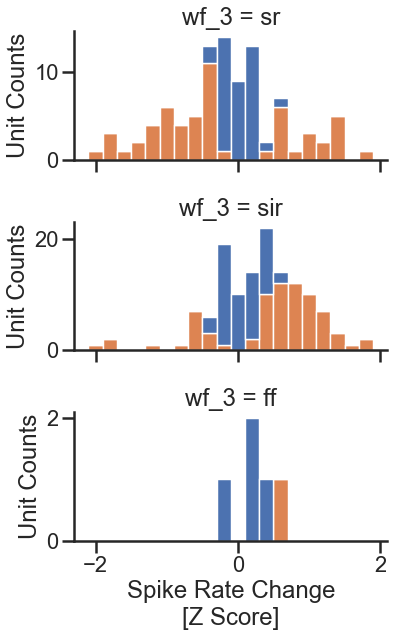

In [200]:
# Anova level

transformer = ShockUtils()
df_aligned = transformer.aligned_binned_from_spikes(
    df_spikes, 
    df_events, 
    session=None,
    bin_width=0.01,
    )
anova, contrasts =  ShortTsAnova().get_responders(
    df_aligned, z=True, clusters=neurons[["neuron_id", "wf_3"]],
    )
display(anova)
display(contrasts)

# Neuron Level
unit_mod = ShortTsAvg()
responders = unit_mod.get_responders(df_aligned, z=True)
unit_mod.plot_responders(responders, clusters=neurons[["neuron_id", "wf_3"]])

sns.despine()
print((responders["p"] < 0.05).mean())

In [228]:
from scipy.ndimage import gaussian_filter1d

df_aligned = transformer.aligned_binned_from_spikes(
    df_spikes, 
    df_events, 
    session=None,
    bin_width=0.01,
    )
df_avg = transformer.average_trace_from_aligned_binned(df_aligned).apply(gaussian_filter1d, sigma=2).apply(zscore)

<AxesSubplot:xlabel='bin', ylabel='neuron_id'>

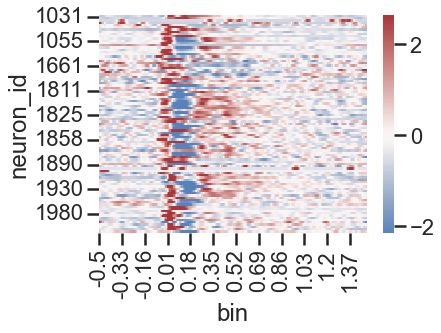

In [259]:
by_cluster = ClusterUtils().cluster_from_piv(df_avg, clusters=neurons[["neuron_id", "wf_3"]])


sns.heatmap(by_cluster["sr"].transpose(), center=0, robust=True, cmap="vlag")

c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\pingouin\effsize.py:670: UserWarning: x and y have unequal sizes. Switching to paired == False.
  warnings.warn("x and y have unequal sizes. Switching to "
c:\Users\roryl\.conda\envs\drn-interactions\lib\site-packages\pingouin\parametric.py:205: UserWarning: x and y have unequal sizes. Switching to paired == False. Check your data.
  warnings.warn("x and y have unequal sizes. Switching to "


,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,wf_3,0.005,2,235,0.003,0.207,0.813,0.002,NaN
1,prepost,0.001,1,235,0.001,0.028,0.868,0.000,1.0
2,Interaction,0.008,2,235,0.004,0.207,0.813,0.002,NaN


,Contrast,wf_3,A,B,T,dof,Tail,p-unc,p-corr,Sig
0,wf_3,-,ff,sir,-0.624,5.156,two-sided,0.559,0.559,
1,wf_3,-,ff,sr,-0.798,5.485,two-sided,0.458,0.559,
2,wf_3,-,sir,sr,-0.748,157.042,two-sided,0.456,0.559,
3,prepost,-,post,pre,-0.167,237.000,two-sided,0.868,NaN,
4,wf_3 * prepost,ff,post,pre,-0.048,150.626,two-sided,0.962,0.962,
5,wf_3 * prepost,sir,post,pre,0.256,3533.401,two-sided,0.798,0.962,
6,wf_3 * prepost,sr,post,pre,-0.517,2538.939,two-sided,0.606,0.962,


0.07563025210084033


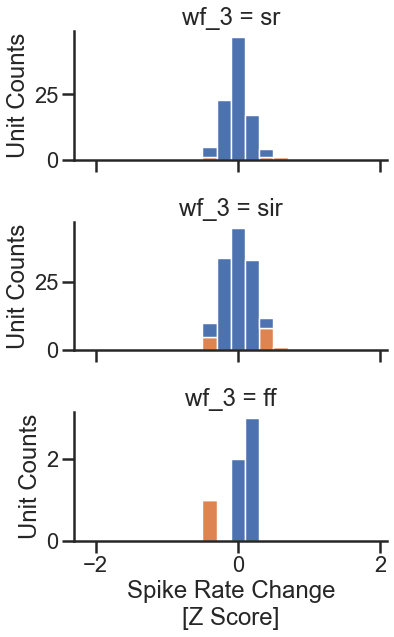

In [201]:
# surrogate data

df_spikes_surr = shuffled_isi_spiketrains_by(
    df_spikes, spiketimes_col="spiketimes",
    by_col="neuron_id"
).merge(neurons_sub)

transformer = ShockUtils()
df_aligned = transformer.aligned_binned_from_spikes(
    df_spikes_surr, 
    df_events, 
    session=None,
    bin_width=0.01,
    )
anova, contrasts =  ShortTsAnova().get_responders(
    df_aligned, z=True, clusters=neurons[["neuron_id", "wf_3"]],
    )
display(anova)
display(contrasts)

# Neuron Level
unit_mod = ShortTsAvg()
responders = unit_mod.get_responders(df_aligned, z=True)
unit_mod.plot_responders(responders, clusters=neurons[["neuron_id", "wf_3"]])

sns.despine()
print((responders["p"] < 0.05).mean())